In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [3]:
from functools import partial

import torch
import einops
from matplotlib import pyplot as plt

from torch_random_fields.utils.misc import compute_energy, make_grid_edges, local_seed
from torch_random_fields.utils.loopy_belief_propagation import loopy_belief_propagation

# Fast Implementation of LBP

## Tests on Potts Model

In [4]:
POTTS = 'POTTS'
CURRENT_CELL = POTTS

size = 10
n_states = 10

with local_seed(2):
    x = torch.normal(mean=0.0, std=1.0, size=(size, size, n_states))
    binary_edges = torch.tensor(make_grid_edges(x))
    binary_potentials = torch.normal(mean=0.0, std=1.0, size=(binary_edges.shape[0], n_states, n_states))
    unary_potentials = x.reshape(-1, n_states)
    args = (unary_potentials, binary_potentials, binary_edges)
    E = partial(compute_energy, *args)

### Benchmark on different methods

In [4]:
assert CURRENT_CELL == POTTS

%timeit loopy_belief_propagation(*args)
%timeit loopy_belief_propagation(*args, max_iter=30)

8.92 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.1 ms ± 917 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
labels = loopy_belief_propagation(
    unary_potentials, 
    binary_potentials, 
    binary_edges, 
)
print(labels)
print(E(labels=labels))

tensor([5, 4, 7, 1, 0, 2, 7, 9, 8, 1, 3, 9, 6, 4, 9, 1, 1, 0, 5, 1, 7, 7, 2, 4,
        2, 4, 6, 6, 3, 4, 8, 4, 9, 0, 8, 4, 2, 3, 2, 5, 0, 2, 9, 5, 0, 8, 8, 3,
        6, 4, 7, 8, 0, 9, 4, 6, 0, 3, 5, 2, 5, 0, 0, 5, 2, 4, 6, 2, 8, 6, 7, 5,
        6, 2, 4, 2, 5, 9, 1, 1, 0, 9, 5, 7, 8, 1, 8, 2, 4, 0, 2, 5, 6, 7, 1, 9,
        7, 8, 7, 2])
tensor(269.6953)


In [6]:
assert CURRENT_CELL == POTTS

# larger is better
print("parallel")
print(E(labels=loopy_belief_propagation(*args)))
print(E(labels=loopy_belief_propagation(*args, track_best=True)))
print(E(labels=loopy_belief_propagation(*args, max_iter=30, track_best=True)))

parallel
tensor(269.6953)
tensor(285.8254)
tensor(297.4042)


### Benchmark on different hyper-parameters

/Users/admin/opt/miniconda3/envs/pystruct3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/admin/opt/miniconda3/envs/pystruct3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


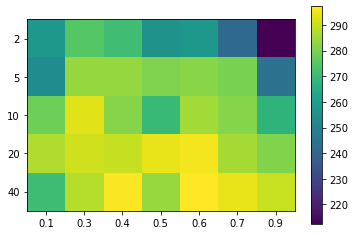

In [8]:
assert CURRENT_CELL == POTTS

iters = [2, 5, 10, 20, 40]
dampings = [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
energies = torch.zeros(size=[len(iters), len(dampings)])

for i, iter_num in enumerate(iters):
    for j, damping in enumerate(dampings):
        res = loopy_belief_propagation(*args, max_iter=iter_num, damping=damping)
        energies[i][j] = compute_energy(*args, labels=res)

fig, ax = plt.subplots(1,1)

ax.imshow(energies)
img = ax.imshow(energies)

ax.set_yticklabels(list(map(str, [None] + iters)))
ax.set_xticklabels(list(map(str, [None] + dampings)))

plt.colorbar(img)

## Tests on Easy Linear-Chain

Only adajcent nodes have binary potentials, which should have exact solution (Viterbi).

In [9]:
EAXCT_LINEAR_CHAIN = 'EAXCT_LINEAR_CHAIN'
CURRENT_CELL = EAXCT_LINEAR_CHAIN

size = 25
n_states = 32

with local_seed(2):
    unary_potentials = torch.abs(torch.normal(mean=0, std=1, size=(size, n_states)))

    binary_edges = torch.tensor([[i, i+1] for i in range(size - 1)])
    binary_potentials = torch.abs(torch.normal(mean=0, std=2, size=(binary_edges.shape[0], n_states, n_states)))

    args = (unary_potentials, binary_potentials, binary_edges)
    E = partial(compute_energy, *args)

In [13]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

# %timeit inference_max_product(*args)   # should be viterbi
%timeit loopy_belief_propagation(*args)
%timeit loopy_belief_propagation(*args, track_best=True)

8.05 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

# benchmark on accuracy
# print("viterbi")
# print(E(labels=inference_max_product(*args)))  # should be viterbi
# print(E(labels=tree_max_product(*args)))  # should be viterbi
print("lbp")
print(E(labels=loopy_belief_propagation(*args)))
print(E(labels=loopy_belief_propagation(*args, max_iter=30, track_best=True)))
print(E(labels=loopy_belief_propagation(*args, track_best=True)))

lbp
tensor(164.7443)
tensor(164.7443)
tensor(164.7443)


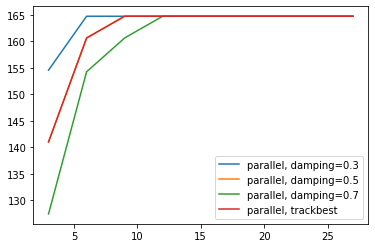

In [11]:
assert CURRENT_CELL == EAXCT_LINEAR_CHAIN

iter_nums = list(range(3, 30, 3))
for damping in [0.3, 0.5, 0.7]:
    energies = []
    for iter_num in iter_nums:
        energies.append(E(labels=loopy_belief_propagation(*args, max_iter=iter_num, damping=damping)))
    plt.plot(iter_nums, energies, label=f'parallel, damping={damping}')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=loopy_belief_propagation(*args, max_iter=iter_num, damping=0.5, track_best=True)))
plt.plot(iter_nums, energies, label='parallel, trackbest')

plt.legend()

## Tests on skip binary linear chain

A-B-C-D-E

- skip-0 binaries: A-B, B-C, ...
- skip-1 binaries: A-C, B-D, ...
- skip-2 binaries: A-D, B-E, ...

In [12]:
SKIP_BINARY_LINEAR_CHAIN = 'SKIP_BINARY_LINEAR_CHAIN'
CURRENT_CELL = SKIP_BINARY_LINEAR_CHAIN

size = 25
n_states = 32

with local_seed(2):
    unary_potentials = torch.abs(torch.normal(mean=0, std=1, size=(size, n_states)))

    binary_edges = torch.tensor(
        [[i, i+1] for i in range(size - 1)] + #
        [[i, i+2] for i in range(size - 2)] + #
        [[i, i+3] for i in range(size - 3)] 
    )
    binary_potentials = torch.abs(torch.normal(mean=0, std=2, size=(binary_edges.shape[0], n_states, n_states))) * 2

    args = (unary_potentials, binary_potentials, binary_edges)
    E = partial(compute_energy, *args)

In [19]:
assert CURRENT_CELL == SKIP_BINARY_LINEAR_CHAIN

%timeit loopy_belief_propagation(*args)
%timeit loopy_belief_propagation(*args, max_iter=30, track_best=True)


10.7 ms ± 879 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.6 ms ± 702 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
assert CURRENT_CELL == SKIP_BINARY_LINEAR_CHAIN

print(E(labels=loopy_belief_propagation(*args)))
print(E(labels=loopy_belief_propagation(*args, track_best=True)))
print(E(labels=loopy_belief_propagation(*args, max_iter=30, track_best=True)))
print(E(labels=loopy_belief_propagation(*args, max_iter=60, track_best=True)))

tensor(493.1441)
tensor(499.3349)
tensor(504.4357)
tensor(504.4357)


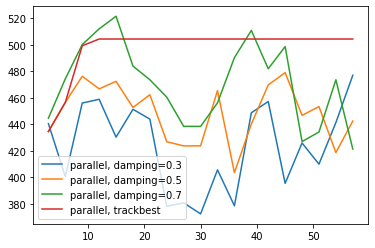

In [14]:
assert CURRENT_CELL == SKIP_BINARY_LINEAR_CHAIN

iter_nums = list(range(3, 60, 3))
for damping in [0.3, 0.5, 0.7]:
    energies = []
    for iter_num in iter_nums:
        energies.append(E(labels=loopy_belief_propagation(*args, max_iter=iter_num, damping=damping)))
    plt.plot(iter_nums, energies, label=f'parallel, damping={damping}')

energies = []
for iter_num in iter_nums:
    energies.append(E(labels=loopy_belief_propagation(*args, max_iter=iter_num, damping=0.5, track_best=True)))
plt.plot(iter_nums, energies, label='parallel, trackbest')

plt.legend()

# Implementation of LBP with Ternary Potentials

A-B-C-D-E

- binaries: A-B, B-C, ...
- ternaries: A-B-C, B-C-D, ...

In [15]:
TERNARY_LINEAR_CHAIN = 'TERNARY_LINEAR_CHAIN'
CURRENT_CELL = TERNARY_LINEAR_CHAIN


size = 25
n_states = 32

with local_seed(2):
    x = torch.abs(torch.normal(mean=0, std=1, size=(size, size, n_states)))
    unary_potentials = x.reshape(-1, n_states)

    binary_edges = torch.tensor([[i, i+1] for i in range(size - 1)])
    binary_potentials = torch.abs(torch.normal(mean=0, std=2, size=(binary_edges.shape[0], n_states, n_states))) * 2

    ternary_edges = torch.tensor([[i, i+1, i+2] for i in range(size - 2)])
    ternary_potentials = torch.abs(torch.normal(mean=0, std=4, size=(ternary_edges.shape[0], n_states, n_states, n_states))) * 2


In [16]:
assert CURRENT_CELL == TERNARY_LINEAR_CHAIN

bin_args = (unary_potentials, binary_potentials, binary_edges)
ter_args = (unary_potentials, binary_potentials, binary_edges, ternary_potentials, ternary_edges)

label_unary_binary_ternary = loopy_belief_propagation(*ter_args, damping=0.5)
print("unary+binary+ternary", compute_energy(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = loopy_belief_propagation(*ter_args, max_iter=10, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = loopy_belief_propagation(*ter_args, max_iter=30, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy(*ter_args, label_unary_binary_ternary))

unary+binary+ternary tensor(1909.8806)
unary+binary+ternary tensor(1960.1089)
unary+binary+ternary tensor(2017.4580)


In [17]:
assert CURRENT_CELL == TERNARY_LINEAR_CHAIN

bin_args = (unary_potentials, binary_potentials, binary_edges)
ter_args = (unary_potentials, binary_potentials, binary_edges, ternary_potentials, ternary_edges)

label_unary = unary_potentials.argmax(axis=1)
print("unary", compute_energy(*ter_args, label_unary))

label_unary_binary = loopy_belief_propagation(*bin_args)
print("unary+binary", compute_energy(*ter_args, label_unary_binary))

label_unary_binary_ternary = loopy_belief_propagation(*ter_args, damping=0.5)
print("unary+binary+ternary", compute_energy(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = loopy_belief_propagation(*ter_args, max_iter=10, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy(*ter_args, label_unary_binary_ternary))

label_unary_binary_ternary = loopy_belief_propagation(*ter_args, max_iter=30, damping=0.5, track_best=True)
print("unary+binary+ternary", compute_energy(*ter_args, label_unary_binary_ternary))


unary tensor(1660.4791)
unary+binary tensor(1827.9442)
unary+binary+ternary tensor(1909.8806)
unary+binary+ternary tensor(1960.1089)
unary+binary+ternary tensor(2017.4580)
